In [1]:
import earthaccess
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
from metpy.constants import *
#from tools import time_from_attr
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from tqdm import tqdm

/srv/conda/envs/notebook/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


# Import and format data

In [4]:
results = earthaccess.search_data(
    short_name="PACE_HARP2_L3M_CLOUD_GPC_NRT",
    granule_name="*.DAY.*.0p1deg.*"
)
print(len(results))

paths = earthaccess.open(results)

35


QUEUEING TASKS | :   0%|          | 0/35 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/35 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/35 [00:00<?, ?it/s]

In [5]:
dataset = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="date",
)
dataset

<xarray.Dataset> Size: 6GB
Dimensions:                               (date: 35, lat: 1800, lon: 3600)
Coordinates:
  * lat                                   (lat) float32 7kB 89.95 ... -89.95
  * lon                                   (lon) float32 14kB -179.9 ... 180.0
Dimensions without coordinates: date
Data variables:
    cloud_bow_droplet_effective_radius    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_droplet_effective_variance  (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_rms                         (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_fit_correlation             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_0             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_1             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_liquid_index                    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
Attributes: (12/54)
    product_name:                      PACE_HARP2.20250701.L3m.DAY.CLOUD_GPC....
    instrument:                        HARP2
    title:                             HARP2 Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from HARP2-PACE
    ...                                ...
    keywords:                          
    id:                                L3/PACE_HARP2.20250701.L3m.DAY.CLOUD_G...
    history:                           l3mapmerge.py -v l3mapmerge_inputs.txt...
    processing_version:                3.0
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/PACE/HARP2/L3M/CLOUD/3.0

In [6]:
def calc_DE_params(er,ev):
    '''
    Calculate the beta, LN, b parameters
    from Wang et al. 2025
    '''
    ev_u = ev * units('')
    er_u = er * units('um')
    beta = ((1-ev_u)*(1-2*ev_u))**(-1/3)
    A = 4/3 * np.pi * density_water
    LN = A * (1-ev_u) * (1-2*ev_u) * er_u**3
    return(beta,LN.metpy.convert_units('g'))

In [7]:
dataset=dataset.assign(beta = (['date','lat','lon'],calc_DE_params(dataset.cloud_bow_droplet_effective_radius,dataset.cloud_bow_droplet_effective_variance)[0].data))
dataset=dataset.assign(LN = (['date','lat','lon'],calc_DE_params(dataset.cloud_bow_droplet_effective_radius,dataset.cloud_bow_droplet_effective_variance)[1].data))
dataset

<xarray.Dataset> Size: 8GB
Dimensions:                               (date: 35, lat: 1800, lon: 3600)
Coordinates:
  * lat                                   (lat) float32 7kB 89.95 ... -89.95
  * lon                                   (lon) float32 14kB -179.9 ... 180.0
Dimensions without coordinates: date
Data variables:
    cloud_bow_droplet_effective_radius    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_droplet_effective_variance  (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_rms                         (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_fit_correlation             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_0             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_1             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_liquid_index                    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    beta                                  (date, lat, lon) float32 907MB <Qua...
    LN                                    (date, lat, lon) float32 907MB <Qua...
Attributes: (12/54)
    product_name:                      PACE_HARP2.20250701.L3m.DAY.CLOUD_GPC....
    instrument:                        HARP2
    title:                             HARP2 Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from HARP2-PACE
    ...                                ...
    keywords:                          
    id:                                L3/PACE_HARP2.20250701.L3m.DAY.CLOUD_G...
    history:                           l3mapmerge.py -v l3mapmerge_inputs.txt...
    processing_version:                3.0
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/PACE/HARP2/L3M/CLOUD/3.0

In [8]:
ds_mean = dataset.mean(dim='date')

# Plotting

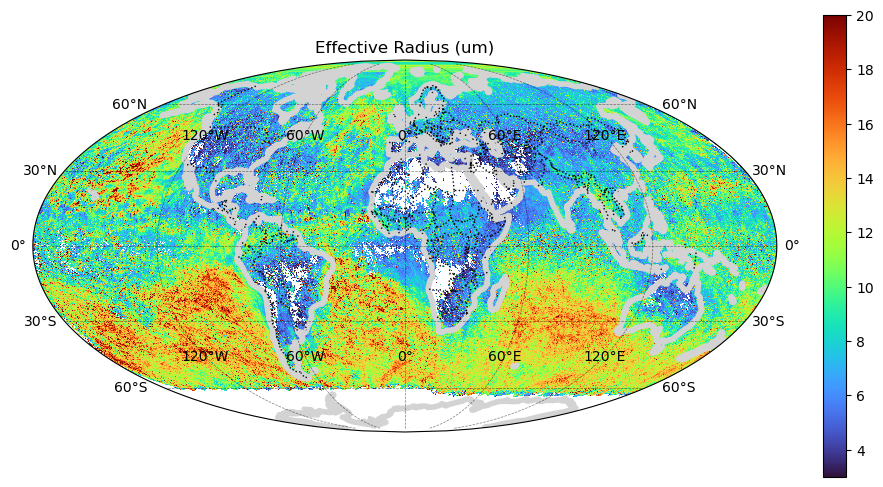

In [40]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.cloud_bow_droplet_effective_radius,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='turbo',vmax=20)
fig.colorbar(im,shrink=0.6)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('Effective Radius (um)')
plt.show()

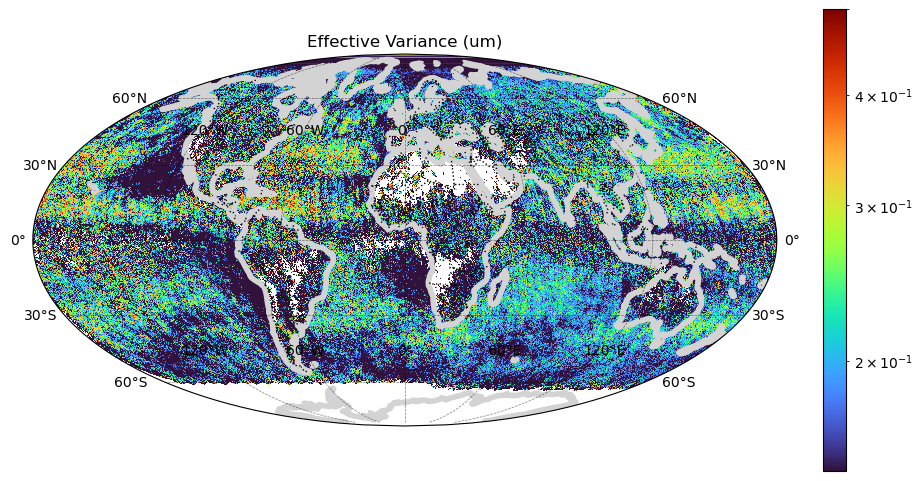

In [25]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.cloud_bow_droplet_effective_variance,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='turbo',norm=LogNorm(vmin=0.15,vmax=0.5))
fig.colorbar(im,shrink=0.6)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('Effective Variance')
plt.show()

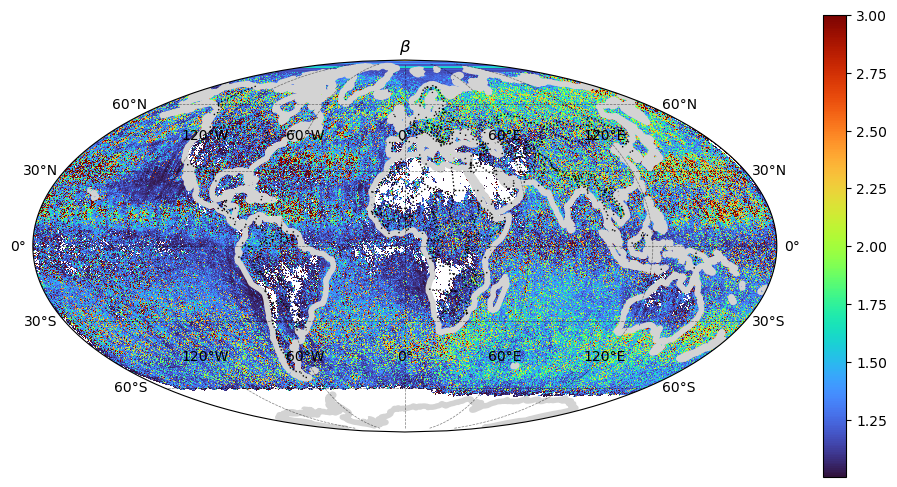

In [24]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.beta,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='turbo',vmax = 3)
fig.colorbar(im,shrink=0.6)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'$\beta$')
plt.show()

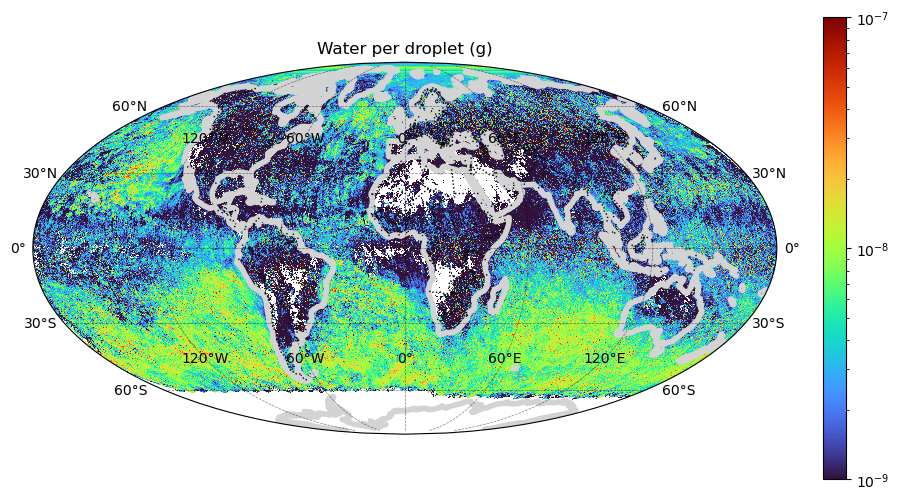

In [34]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.LN.metpy.convert_units('g'),
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='turbo',norm=LogNorm(vmin=1e-9,vmax=1e-7))
fig.colorbar(im,shrink=0.6)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('Water per droplet (g)')
plt.show()

## Matching Fig 1 
(https://www.nature.com/articles/s41467-025-62238-3)

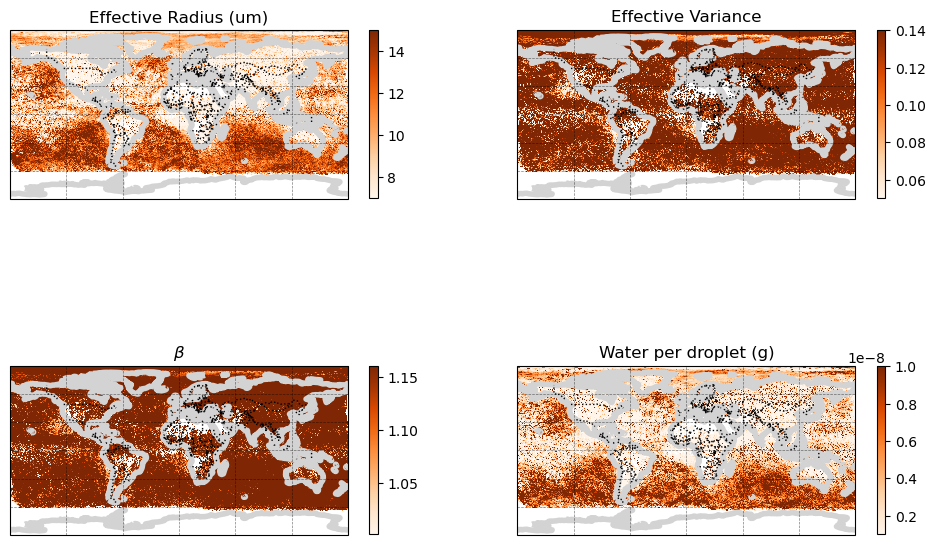

In [47]:

cm = 'Oranges'


fig = plt.figure(figsize=[12,8])

ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.cloud_bow_droplet_effective_radius,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmin=7,vmax=15)
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('Effective Radius (um)')



ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.cloud_bow_droplet_effective_variance,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmin=0.05,vmax=0.14)#,norm=LogNorm(vmin=0.15,vmax=0.5))
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('Effective Variance')




ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.beta,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmax = 1.16)
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'$\beta$')


ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.LN.metpy.convert_units('g'),
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmin=1e-9,vmax=1e-8)#norm=LogNorm(vmin=1e-9,vmax=1e-7))
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('Water per droplet (g)')


plt.show()

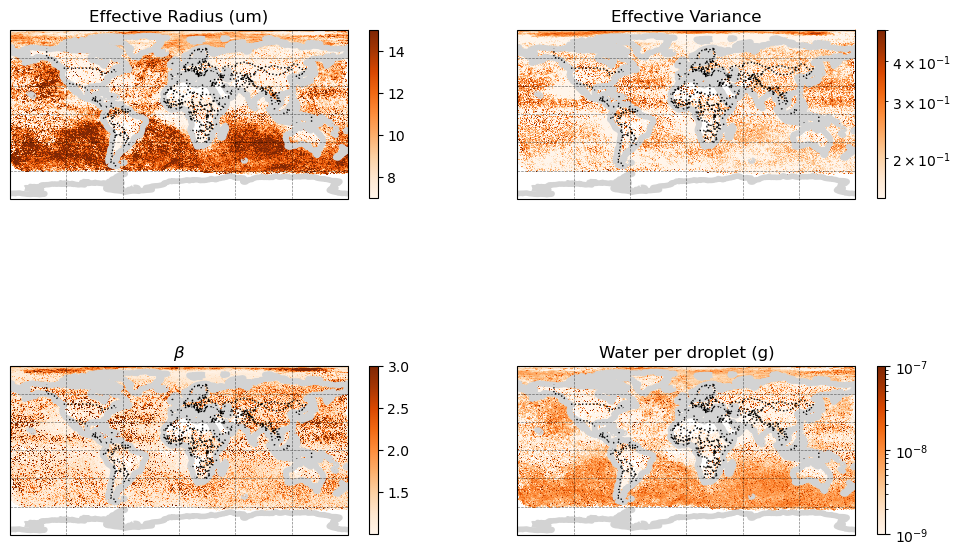

In [51]:

cm = 'Oranges'


fig = plt.figure(figsize=[12,8])

ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.cloud_bow_droplet_effective_radius,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmin=7,vmax=15)
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('Effective Radius (um)')



ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.cloud_bow_droplet_effective_variance,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,norm=LogNorm(vmin=0.15,vmax=0.5))
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('Effective Variance')




ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.beta,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmax = 3)
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'$\beta$')


ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.LN.metpy.convert_units('g'),
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,norm=LogNorm(vmin=1e-9,vmax=1e-7))
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('Water per droplet (g)')


plt.show()

In [1]:
ds_mean.cloud_bow_droplet_effective_variance.max

NameError: name 'ds_mean' is not defined

# Calculating b

In [9]:
lat_floor = np.floor(ds_mean.lat)
lon_floor = np.floor(ds_mean.lon)
ds_mean = ds_mean.assign(lat_floor=(['lat'],lat_floor.data))
ds_mean = ds_mean.assign(lon_floor=(['lon'],lon_floor.data))

ds_mean

<xarray.Dataset> Size: 233MB
Dimensions:                               (lat: 1800, lon: 3600)
Coordinates:
  * lat                                   (lat) float32 7kB 89.95 ... -89.95
  * lon                                   (lon) float32 14kB -179.9 ... 180.0
Data variables:
    cloud_bow_droplet_effective_radius    (lat, lon) float32 26MB dask.array<chunksize=(512, 1024), meta=np.ndarray>
    cloud_bow_droplet_effective_variance  (lat, lon) float32 26MB dask.array<chunksize=(512, 1024), meta=np.ndarray>
    cloud_bow_rms                         (lat, lon) float32 26MB dask.array<chunksize=(512, 1024), meta=np.ndarray>
    cloud_bow_fit_correlation             (lat, lon) float32 26MB dask.array<chunksize=(512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_0             (lat, lon) float32 26MB dask.array<chunksize=(512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_1             (lat, lon) float32 26MB dask.array<chunksize=(512, 1024), meta=np.ndarray>
    cloud_liquid_index                    (lat, lon) float32 26MB dask.array<chunksize=(512, 1024), meta=np.ndarray>
    beta                                  (lat, lon) float32 26MB <Quantity(d...
    LN                                    (lat, lon) float32 26MB <Quantity(d...
    lat_floor                             (lat) float32 7kB 89.0 89.0 ... -90.0
    lon_floor                             (lon) float32 14kB -180.0 ... 179.0

In [10]:
def fit(LN,a,b):
    return(a*LN**b)

In [11]:
def find_b(LN,beta):
        #print(ds.lat)
    LN = LN.flatten()
    beta = beta.flatten()
    mask = ~np.isnan(LN)&~np.isnan(beta)
    if mask.sum()>1:
        try:
            popt,pcov = curve_fit(fit,LN[mask],beta[mask])
            #print(popt[0])
            out = popt[1]
        except:
            out=np.nan
            print('fit failure')
    else:
        #print('no values')
        out = np.nan
    return(out)

In [12]:
ds_mean_floor = ds_mean.set_index(lat='lat_floor',lon='lon_floor')
ds_LN = ds_mean_floor.LN.compute()
ds_beta = ds_mean_floor.beta.compute()
ds_lnbeta = xr.merge((ds_LN,ds_beta))
ds_lnbeta

<xarray.Dataset> Size: 52MB
Dimensions:  (lat: 1800, lon: 3600)
Coordinates:
  * lat      (lat) float32 7kB 89.0 89.0 89.0 89.0 ... -90.0 -90.0 -90.0 -90.0
  * lon      (lon) float32 14kB -180.0 -180.0 -180.0 ... 179.0 179.0 179.0
Data variables:
    LN       (lat, lon) float32 26MB <Quantity([[2.6256957e-09 2.6256957e-09 ...
    beta     (lat, lon) float32 26MB <Quantity([[1.6782315 1.6782315 1.678231...

In [13]:
lats = np.arange(-90,90,1)
lons = np.arange(-180,180,1)
bs = np.zeros((180,360))
i = 0
j = 0

for lat in tqdm(lats):
    for lon in lons:
        ds = ds_lnbeta.sel(lat=lat).sel(lon=lon)
        LN = ds.LN.data.magnitude
        beta=ds.beta.data.magnitude
        bs[lat+90,lon+180]=find_b(LN,beta)

/tmp/ipykernel_5885/3847617344.py:2: RuntimeWarning: overflow encountered in power
  return(a*LN**b)
/tmp/ipykernel_5885/3411737237.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(fit,LN[mask],beta[mask])
 15%|█▌        | 27/180 [00:08<00:56,  2.71it/s]

fit failure


 16%|█▌        | 28/180 [00:08<01:04,  2.37it/s]

fit failure
fit failure


 16%|█▌        | 29/180 [00:09<01:16,  1.97it/s]

fit failure


 19%|█▉        | 34/180 [00:15<02:38,  1.09s/it]

fit failure


 22%|██▏       | 40/180 [00:22<02:45,  1.19s/it]

fit failure


 41%|████      | 74/180 [00:53<01:52,  1.06s/it]

fit failure


 47%|████▋     | 84/180 [01:03<01:40,  1.05s/it]

fit failure


 62%|██████▏   | 112/180 [01:33<01:09,  1.02s/it]

fit failure


 66%|██████▌   | 119/180 [01:40<00:59,  1.02it/s]

fit failure


 67%|██████▋   | 121/180 [01:41<00:54,  1.08it/s]

fit failure


 91%|█████████ | 163/180 [02:13<00:14,  1.19it/s]

fit failure


 91%|█████████ | 164/180 [02:14<00:13,  1.15it/s]

fit failure


 93%|█████████▎| 168/180 [02:18<00:10,  1.11it/s]

fit failure


 94%|█████████▍| 170/180 [02:20<00:08,  1.12it/s]

fit failure
fit failure
fit failure


 95%|█████████▌| 171/180 [02:21<00:08,  1.12it/s]

fit failure
fit failure
fit failure
fit failure


 96%|█████████▌| 172/180 [02:22<00:07,  1.12it/s]

fit failure
fit failure
fit failure


 96%|█████████▌| 173/180 [02:22<00:06,  1.12it/s]

fit failure


 97%|█████████▋| 175/180 [02:24<00:04,  1.15it/s]

fit failure
fit failure


 98%|█████████▊| 176/180 [02:25<00:03,  1.14it/s]

fit failure


 99%|█████████▉| 178/180 [02:27<00:01,  1.20it/s]

fit failure


100%|██████████| 180/180 [02:28<00:00,  1.21it/s]


In [14]:
bs

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.01167257,  0.07566659,  0.00142089, ...,  0.02530837,
        -0.13602548, -0.16550719],
       [ 0.13869062,  0.13869062,  0.14363808, ..., -0.15529391,
        -0.13398972, -0.13398972],
       [-0.05584695, -0.05584695, -0.05584695, ..., -0.08156361,
        -0.08156361, -0.08156361]], shape=(180, 360))

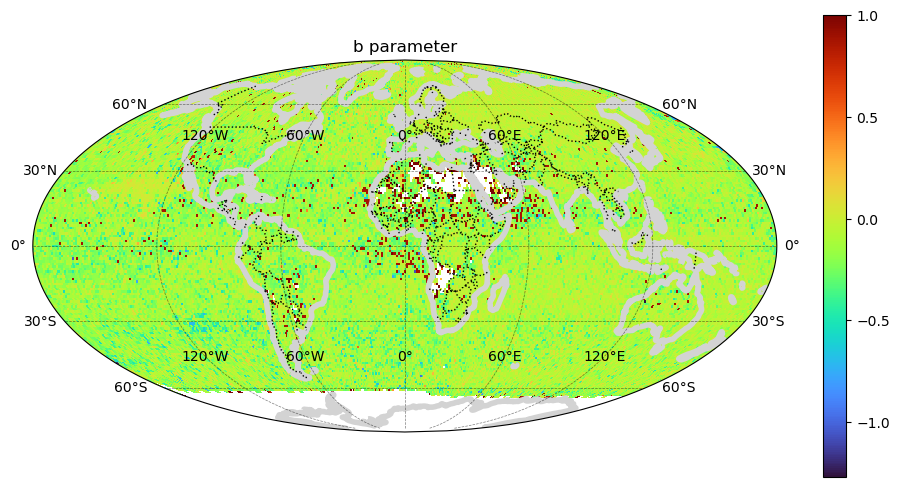

In [15]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,bs[:180,:360],
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='turbo')
fig.colorbar(im,shrink=0.6)
ax.set_aspect("equal")
ax.coastlines(color='lightgray',linewidth=4)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title('b parameter')
plt.show()

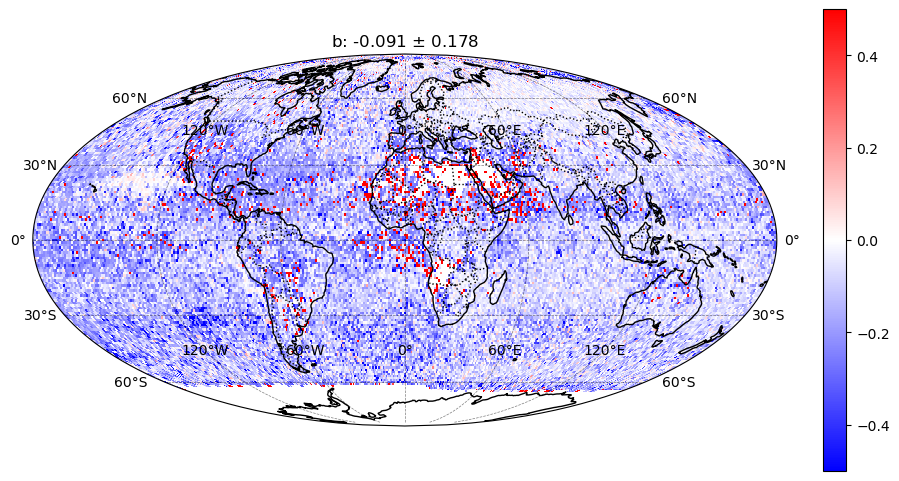

In [16]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,bs[:180,:360],
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='bwr',vmin=-0.5,vmax=0.5)
fig.colorbar(im,shrink=0.6)
ax.set_aspect("equal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
#ax.set_title('b:' + str(np.nanmean(bs))[:7]+r'$\pm$'+str(np.nanstd(bs))[:6])
ax.set_title(r'b: {:.3f} $\pm$ {:.3f}'.format(np.nanmean(bs),np.nanstd(bs)))
plt.show()

In [17]:
DOND = -300*bs
DOLWP = 300*bs/5

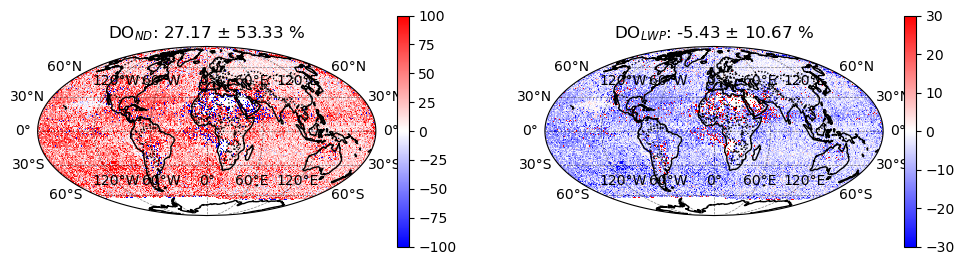

In [80]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,DOND,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='bwr',vmin=-100,vmax=100)
fig.colorbar(im,shrink=0.3)
ax.set_aspect("equal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'DO$_{{ND}}$: {mean:.2f} $\pm$ {std:.2f} %'.format(mean=np.nanmean(DOND),std=np.nanstd(DOND)))


ax = fig.add_subplot(1, 2, 2, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,DOLWP,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='bwr',vmin=-30,vmax=30)
fig.colorbar(im,shrink=0.3)
ax.set_aspect("equal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'DO$_{{LWP}}$: {mean:.2f} $\pm$ {std:.2f} %'.format(mean=np.nanmean(DOLWP),std=np.nanstd(DOLWP)))


plt.show()

# Reducing Uncertainty
We want to filter out the bad fits. 

In [30]:
def find_b(LN,beta):
        #print(ds.lat)
    LN = LN.flatten()
    beta = beta.flatten()
    mask = ~np.isnan(LN)&~np.isnan(beta)
    if mask.sum()>1:
        try:
            popt,pcov = curve_fit(fit,LN[mask],beta[mask])
            #print(popt[0])
            out_opt = popt[1]
            out_p = np.sqrt(np.diag(pcov))[1]
            #out_p = pcov
        except:
            out_opt=np.nan
            out_p = np.nan
            print('fit failure')
    else:
        #print('no values')
        out_opt= np.nan
        out_p = np.nan
    return(out_opt,out_p)

In [48]:
lats = np.arange(-90,90,1)
lons = np.arange(-180,180,1)
bs = np.zeros((180,360))
ps = np.zeros((180,360))
i = 0
j = 0

for lat in tqdm(lats):
    for lon in lons:
        ds = ds_lnbeta.sel(lat=lat).sel(lon=lon)
        LN = ds.LN.data.magnitude
        beta=ds.beta.data.magnitude
        b,p=find_b(LN,beta)
        bs[lat+90,lon+180] = b
        #print(p)
        ps[lat+90,lon+180] = p

/tmp/ipykernel_5885/3847617344.py:2: RuntimeWarning: overflow encountered in power
  return(a*LN**b)
/tmp/ipykernel_5885/1108839657.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(fit,LN[mask],beta[mask])
 15%|█▌        | 27/180 [00:07<00:53,  2.86it/s]

fit failure


 16%|█▌        | 28/180 [00:07<01:01,  2.47it/s]

fit failure
fit failure


 16%|█▌        | 29/180 [00:08<01:11,  2.10it/s]

fit failure


 19%|█▉        | 34/180 [00:12<02:00,  1.21it/s]

fit failure


 22%|██▏       | 40/180 [00:18<02:05,  1.12it/s]

fit failure


 41%|████      | 74/180 [00:48<01:30,  1.17it/s]

fit failure


 47%|████▋     | 84/180 [00:56<01:21,  1.17it/s]

fit failure


 62%|██████▏   | 112/180 [01:20<00:52,  1.29it/s]

fit failure


 66%|██████▌   | 119/180 [01:25<00:46,  1.32it/s]

fit failure


 67%|██████▋   | 121/180 [01:26<00:44,  1.33it/s]

fit failure


 91%|█████████ | 163/180 [02:01<00:15,  1.10it/s]

fit failure


 91%|█████████ | 164/180 [02:02<00:15,  1.07it/s]

fit failure


 93%|█████████▎| 168/180 [02:06<00:11,  1.03it/s]

fit failure


 94%|█████████▍| 170/180 [02:08<00:09,  1.02it/s]

fit failure
fit failure
fit failure
fit failure


 95%|█████████▌| 171/180 [02:09<00:08,  1.03it/s]

fit failure
fit failure
fit failure
fit failure


 96%|█████████▌| 172/180 [02:10<00:08,  1.00s/it]

fit failure
fit failure


 96%|█████████▌| 173/180 [02:11<00:06,  1.01it/s]

fit failure


 97%|█████████▋| 175/180 [02:13<00:04,  1.03it/s]

fit failure
fit failure


 98%|█████████▊| 176/180 [02:14<00:03,  1.02it/s]

fit failure


 99%|█████████▉| 178/180 [02:16<00:01,  1.08it/s]

fit failure


100%|██████████| 180/180 [02:17<00:00,  1.31it/s]


In [49]:
mask = ~np.isnan(ps)
print(np.sum(mask),np.sum(ps<0.05),np.sum(ps<0.05)/np.sum(mask))

54431 38445 0.7063070676636476


In [50]:
bs_good = bs[:,:]
bs_good[ps>0.05]=np.nan

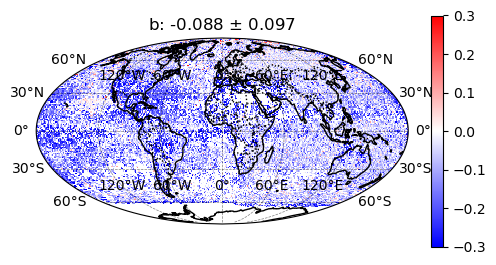

In [56]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,bs_good,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='bwr',vmin=-0.3,vmax=0.3)
fig.colorbar(im,shrink=0.6)
ax.set_aspect("equal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
#ax.set_title('b:' + str(np.nanmean(bs))[:7]+r'$\pm$'+str(np.nanstd(bs))[:6])
ax.set_title(r'b: {:.3f} $\pm$ {:.3f}'.format(np.nanmean(bs),np.nanstd(bs)))
plt.show()

In [52]:
DOND = -300*bs_good
DOLWP = 300*bs_good/5

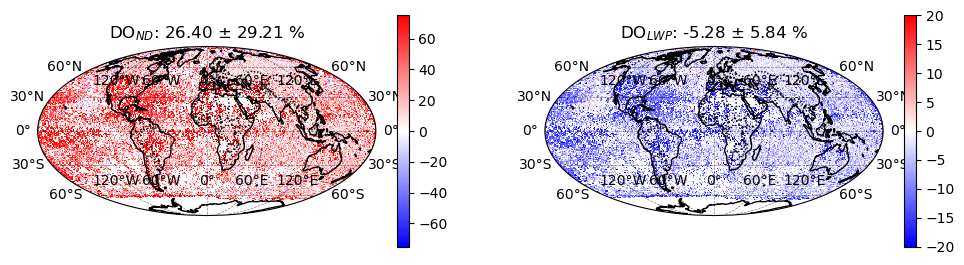

In [57]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,DOND,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='bwr',vmin=-75,vmax=75)
fig.colorbar(im,shrink=0.3)
ax.set_aspect("equal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'DO$_{{ND}}$: {mean:.2f} $\pm$ {std:.2f} %'.format(mean=np.nanmean(DOND),std=np.nanstd(DOND)))


ax = fig.add_subplot(1, 2, 2, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,DOLWP,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='bwr',vmin=-20,vmax=20)
fig.colorbar(im,shrink=0.3)
ax.set_aspect("equal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'DO$_{{LWP}}$: {mean:.2f} $\pm$ {std:.2f} %'.format(mean=np.nanmean(DOLWP),std=np.nanstd(DOLWP)))


plt.show()